<a href="https://colab.research.google.com/github/ram130849/Deep_Learning_Systems_Assignments/blob/main/TensorFlow/Tejas/Deep_Learning_HW5_Q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HW5

References:
*   



##GPU Check

In [1]:
#Path: TensorFlow/Tejas/
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.2


In [3]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.4448180969999953
GPU (s):
0.038347337999994124
GPU speedup over CPU: 11x


##Dependencies

In [4]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
import keras.utils
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers import  Dense, Dropout, Activation, Flatten
from librosa.core import stft,istft
import soundfile as sf
from sklearn.model_selection import train_test_split
import tensorflow as tf
import librosa
import itertools

import imageio
%matplotlib inline



##Load Dataset

In [5]:
(X_train,y_train),(X_test,y_test)=keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [6]:
print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

X_train:  (60000, 28, 28)
X_test:  (10000, 28, 28)
y_train:  (60000,)
y_test:  (10000,)


In [7]:
X_train = X_train.reshape(-1,784)
X_test = X_test.reshape(-1,784)

In [8]:
print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)

X_train:  (60000, 784)
X_test:  (10000, 784)


##Scaling

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
rescale=MinMaxScaler(feature_range=(-1,1))

In [11]:
X_train_sc=rescale.fit_transform(X_train)
X_test_sc=rescale.fit_transform(X_test)

In [12]:
print("X_train_sc: ",X_train_sc.shape)
print("X_test_sc: ",X_test_sc.shape)

X_train_sc:  (60000, 784)
X_test_sc:  (10000, 784)


In [13]:
batch_size = 100
num_classes = 10
image_size = 784 #Flatten image
latent_dim = 100
middle_image= (10*10)

In [14]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [15]:
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

y_train:  (60000, 10)
y_test:  (10000, 10)


In [16]:
all_image = np.concatenate([X_train_sc,X_test_sc])
all_image = all_image.astype('float32')
all_label = np.concatenate([y_train,y_test])

In [17]:
all_image.shape

(70000, 784)

In [18]:
all_label.shape

(70000, 10)

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((all_image, all_label))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [20]:
print("Shape of training images: {}".format(all_image.shape))
print("Shape of training labels: {}".format(all_label.shape))

Shape of training images: (70000, 784)
Shape of training labels: (70000, 10)


In [21]:

gen_input = latent_dim + middle_image
dis_input = image_size 
print("Generator Input Size:",gen_input)
print("Discriminator Input Size:",dis_input)

Generator Input Size: 200
Discriminator Input Size: 784


##Model
Following Professors model an keeping leaky relu and tanh activations.



In [22]:
# Following Profssors Model.
discriminator = keras.Sequential(
    [   
        keras.layers.InputLayer((dis_input,)),
        layers.Dense(400,kernel_initializer = tf.keras.initializers.HeNormal(), activation = tf.nn.leaky_relu),
        layers.Dense(200,kernel_initializer = tf.keras.initializers.HeNormal(), activation = tf.nn.leaky_relu),
        layers.Dense(100,kernel_initializer = tf.keras.initializers.HeNormal(), activation = tf.nn.leaky_relu),
        layers.Dense(1,kernel_initializer = tf.keras.initializers.HeNormal())
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((gen_input,)),
        layers.Dense(200,kernel_initializer = tf.keras.initializers.HeNormal()),
        layers.BatchNormalization(momentum=0.5),
        layers.Dense(400,kernel_initializer = tf.keras.initializers.HeNormal()),
        layers.BatchNormalization(momentum=0.5),
        layers.Dense(784,kernel_initializer = tf.keras.initializers.HeNormal(),activation='tanh')
    ],
    name="generator",
)

In [23]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 400)               314000    
                                                                 
 dense_1 (Dense)             (None, 200)               80200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 414,401
Trainable params: 414,401
Non-trainable params: 0
_________________________________________________________________


In [24]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 200)               40200     
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dense_5 (Dense)             (None, 400)               80400     
                                                                 
 batch_normalization_1 (Batc  (None, 400)              1600      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 784)               314384    
                                                                 
Total params: 437,384
Trainable params: 436,184
Non-train

In [25]:
class Cond_GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(Cond_GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.real_acc_tracker = tf.keras.metrics.BinaryAccuracy(name="real_acc")
        self.fake_acc_tracker = tf.keras.metrics.BinaryAccuracy(name="fake_acc")
    
    def middle_patch(self,data):
        real_images, one_hot_labels = data
        #image_data = real_images.reshape(-1,28,28)
        image_data = tf.reshape(real_images,shape=(-1,28,28))
        #print(image_data.shape)
        middle_images = image_data[:,10:20,10:20]
        #print(middle_images.shape)
        #new_images = middle_images.reshape(-1,10*10)
        new_images = tf.reshape(middle_images,shape=(-1,10*10))
        #print(new_images.shape)

        return new_images

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker,self.real_acc_tracker,self.fake_acc_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(Cond_GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    def train_step(self, data):
        real_images, one_hot_labels = data
        #print(real_images.shape)
        new_images = self.middle_patch(data)
        #image_data = real_images.reshape(-1,28,28)
        # image_data = tf.reshape(real_images,shape=(-1,28,28))
        # print(image_data.shape)
        # middle_images = image_data[:,10:19,10:19]
        # #new_images = middle_images.reshape(-1,10*10)
        # new_images = tf.reshape(middle_images,shape=(-1,10*10))
        # print(new_images.shape)
        # print('ccccc')

        #one_hot_labels = tf.cast(one_hot_labels, tf.float32)

        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, new_images], axis=1)

        generated_images = self.generator(random_vector_labels)
        
        fake_image_and_labels = generated_images
        real_image_and_labels = real_images
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)

        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        self.fake_acc_tracker.update_state(labels[:batch_size,:],predictions[:batch_size,:])
        self.real_acc_tracker.update_state(labels[batch_size:,:],predictions[batch_size:,:])

        # new_images = self.middle_patch(data)

        # image_data = real_images.reshape(-1,28,28)
        # middle_images = image_data[:,10:19,10:19]
        # new_images = middle_images.reshape(-1,10*10)

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        #print(random_latent_vectors.shape)
        random_vector_labels = tf.concat([random_latent_vectors, new_images], axis=1)
        #print(random_vector_labels.shape)
        misleading_labels = tf.zeros((batch_size, 1))

        

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            #fake_image_and_labels = tf.concat([fake_images, new_images], -1)
            predictions1 = self.discriminator(fake_images)
            g_loss = self.loss_fn(misleading_labels, predictions1)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "real_acc": self.real_acc_tracker.result(),
            "fake_acc": self.fake_acc_tracker.result()
        }

In [26]:
#type(dataset)

In [30]:
cond_gan = Cond_GAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

history = cond_gan.fit(dataset, epochs=100)

Epoch 1/100
700/700 [==============================] - 5s 5ms/step - g_loss: 1.7322 - d_loss: 0.5929 - real_acc: 0.8119 - fake_acc: 0.5893
Epoch 2/100
700/700 [==============================] - 4s 5ms/step - g_loss: 2.1342 - d_loss: 0.4854 - real_acc: 0.8397 - fake_acc: 0.6438
Epoch 3/100
700/700 [==============================] - 4s 5ms/step - g_loss: 1.9576 - d_loss: 0.5364 - real_acc: 0.8271 - fake_acc: 0.6180
Epoch 4/100
700/700 [==============================] - 4s 5ms/step - g_loss: 2.1136 - d_loss: 0.5350 - real_acc: 0.8050 - fake_acc: 0.6200
Epoch 5/100
700/700 [==============================] - 4s 5ms/step - g_loss: 1.7347 - d_loss: 0.4702 - real_acc: 0.8305 - fake_acc: 0.6050
Epoch 6/100
700/700 [==============================] - 4s 5ms/step - g_loss: 1.5885 - d_loss: 0.5474 - real_acc: 0.8314 - fake_acc: 0.5761
Epoch 7/100
700/700 [==============================] - 4s 5ms/step - g_loss: 2.1101 - d_loss: 0.5290 - real_acc: 0.8206 - fake_acc: 0.6030
Epoch 8/100
700/700 [======

Text(0.5, 1.0, 'Accuracies')

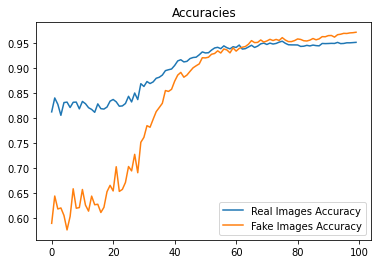

In [31]:
plt.plot(history.history['real_acc'],label='Real Images Accuracy')
plt.plot(history.history['fake_acc'],label='Fake Images Accuracy' )
plt.legend(loc="best")
plt.title("Accuracies")

In [32]:
# noise = np.random.normal(0,1,(100, latent_dim))

# labels=[]
# for x in np.eye(10):
#   for i in range(10):
#     labels.append(x.tolist())
# labels = np.array(labels)

# image = cond_gan.generator.predict(np.concatenate([noise,labels],axis=1))
# image = 0.5 * image + 0.5
# fig, ax = plt.subplots(10,10, figsize = (10,10))
# cnt = 0
# for i in range(10):
#     for j in range(10):
#         ax[i,j].imshow(image[cnt,:].reshape((28,28)))
#         ax[i,j].axis('off')
#         cnt+=1
# plt.show()

In [36]:
print("Generated Images")
noise = np.random.normal(0,1,(10*10, 100))

result = []
for i in range(10):
    result.append(np.array(np.where(y_test == i)[0][:10]))
final_array = np.concatenate(result, axis=0)

mean_patch = tf.reshape(X_test_sc[final_array],shape=[-1,28,28])[:,10:20,10:20]
mean_patch = tf.reshape(mean_patch,[mean_patch.shape[0], -1])

#noise.shape
print(mean_patch.shape)

gen_image = cond_gan.generator.predict(np.concatenate([noise,mean_patch],axis=1))
gen_image = 0.5 * gen_image + 0.5

gen_image = tf.reshape(gen_image,shape=[-1,28,28])

fig, ax = plt.subplots(10,10, figsize = (10,10))
cnt = 0
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(gen_image[cnt,:].reshape((28,28)),cmap = 'gray')
        ax[i,j].axis('off')
        cnt+=1
plt.show()

Generated Images
(20, 100)


ValueError: ignored